Demonstrate making and applying calibration of phase and amplitude for a scan.

In general, the "calbration" data are calculated with a direct loop-back and then are applied to data collected while connected to actual resonators.

In [1]:
import importlib
from mkids import TopSoc
import numpy as np
import matplotlib.pyplot as plt
import Scan
import pickle
soc = TopSoc()

In [2]:
# Define the area to calibrate, based on an (arbitrary) mixer setting
fMixer = soc.fsIn/2/2
soc.set_mixer(fMixer)
f0 = fMixer + 85.4
f1 = fMixer + 95.6
fTone = 0.5*(f0+f1)

measure nominal dealy for fTone=1114.500000  outCh=45


  0%|          | 0/20 [00:00<?, ?it/s]

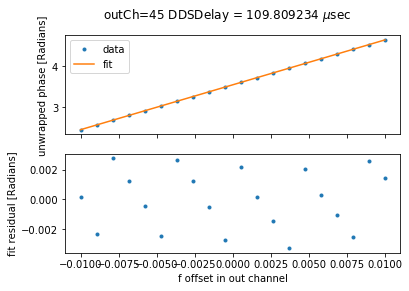

In [3]:
# Measure the nominal delay near fTone
scan = Scan.Scan(soc)
outCh = scan.soc.outFreq2ch(fTone)
print("measure nominal dealy for fTone=%f  outCh=%d"%(fTone, outCh))
nominalDelay = scan.measureNominalDelay(outCh, decimation=2, doProgress=True, doPlot=True)

In [4]:
# Make a calibration with nt transfers at nf frequencies, with the nominalDelay correction applied
nt,nf = 10,201
calibration = scan.makeCalibration(fMixer, f0, f1, nf=nf, nt=nt, doProgress=True,
                            nominalDelay=nominalDelay)
fscan = calibration['fscan']
print("delayApplied =",fscan['delayApplied'])


  0%|          | 0/201 [00:00<?, ?it/s]

delayApplied = 109.80923412034464


In [6]:
# Save this calibration for use in the next tutorial
with open("calibration-demo.pkl", 'wb') as file:
    pickle.dump(calibration, file)

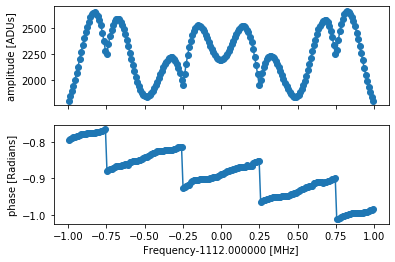

In [5]:
# Take a look at part of the calibration data, for one of the PFB bins
iTone = 2
Scan.fscanPlot(fscan, iTone)


In [ ]:
# For convenience, arrange these points as a single spectrum
spectrum = Scan.fscanToSpectrum(fscan)
# These frequencies define where there will be discontinuities in I,Q values
fList = scan.makeFList(fMixer, f0, f1)


In [ ]:
# Plot the amplitudes, along with vertical lines showing where discontinuities are.  The horizontal green line shows the frequency range requested
plt.plot(spectrum[0],spectrum[1])
for f in fList:
    plt.axvline(f,color='r', alpha=0.4)
aMean = spectrum[1].mean()
plt.plot([f0,f1],[aMean,aMean], 'g')
plt.xlabel("frequency (MHz)")

In [ ]:
# Plot the phases, along with vertical lines showing where discontinuities are
plt.plot(spectrum[0],spectrum[2])
print("f0 =",f0)
print("f1 =",f1)
for f in fList:
    plt.axvline(f,color='r', alpha=0.5)
pMean = spectrum[2].mean()
plt.plot([f0,f1],[pMean, pMean], 'g')
plt.xlabel("frequency (MHz)")

In [ ]:
# zoom in a bit and show I, Q values and discontinuities
fMiddle = 0.5*(f0+f1)
fStart = fMiddle-2.3
fEnd = fMiddle+1.4
inds = (spectrum[0] > fStart ) & (spectrum[0] < fEnd)
sx = spectrum[1]*np.exp(1j*spectrum[2])
si = np.real(sx)
sq = np.imag(sx)
plt.plot(spectrum[0][inds],si[inds], ',', label="I")
plt.plot(spectrum[0][inds],sq[inds], ',', label="Q")
for f in fList:
    plt.axvline(f,color='r', alpha=0.2)
plt.xlim((fStart,fEnd))
plt.legend()
plt.xlabel("frequency (MHz)")
plt.ylabel("values [ADUs]")

In [ ]:
# Pretend we have a few frequencies we want to study.  Define tones of equal amplitude and random phases and scan
nTones = 4
testFreqs = fStart + 2.345*np.arange(nTones)

testAmps = 0.9*np.ones(len(testFreqs))/len(testFreqs)
np.random.seed(1234991)
testFis = np.random.uniform(0, 2*np.pi, size=len(testFreqs))
bandwidth = 0.4 # MHz
nf = 50
decimation = 2
nt = 3
doProgress = True

testFScan = scan.fscan(testFreqs, testAmps, testFis, bandwidth, nf, decimation,nt, doProgress=doProgress)


In [ ]:
# Plot the measured amplitude,phase of one of the tones
Scan.fscanPlot(testFScan, 0)

In [ ]:
# Apply the calibration
tfsCalib = Scan.applyCalibration(testFScan, calibration, amplitudeMax=5000)


In [ ]:
# Plot the calibrated amplitude,phase of one of the tones
Scan.fscanPlot(tfsCalib, 0)